In [1]:
# PAN cohort multiclass classification
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import omicverse as ov
import math
import warnings
from pathlib import Path
import joblib
import matplotlib as mpl
# 忽略所有警告
warnings.filterwarnings("ignore")
print("正在运行在：", os.uname())

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',    None)
pd.set_option('display.width',       1000)

/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/omicverse/utils/_data.py:329: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


正在运行在： posix.uname_result(sysname='Linux', nodename='mirnalab-Super-Server', release='6.8.0-59-generic', version='#61~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 15 17:03:15 UTC 2', machine='x86_64')


In [ ]:
# read data
file_path = Path(r'/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/CA_selected_Masslin2_0801.csv')
data = pd.read_csv(file_path, index_col=0)
# check data
print(data.shape)
print(data.head())
print(data.columns)


(476, 398)
             CandidatusAtelocyanobacterium  Herminiimonas  Paralcaligenes  Wielerella  Syntrophothermus  Conchiformibius  CandidatusNucleicultrix  Sideroxyarcus  Deefgea  Polynucleobacter  Collimonas  Ephemeroptericola  Oligella  Desulfotalea  Pandoraea  Niveibacterium  Paraburkholderia  Bordetella  CandidatusNitrotoga  Kerstersia  Alysiella  Desulfonema  CandidatusVallotia  CandidatusSyntrophocurvum  Pelistega  Sutterella  Noviherbaspirillum  Simonsiella  Taylorella  Ferriphaselus  Mycetohabitans  Advenella  Basilea  Hankyongella  Chromobacterium  Massilistercora  Egicoccus  Bulleidia  Nitrosospira  Magnetococcus  Aquella  Yersinia  Gallionella  Glaciimonas  Sulfuriferula  Usitatibacter  Gluconacetobacter  Sulfurimicrobium  Xylella  Paralysiella  Shinella  Mycoavidus  Bermanella  Sporosarcina  Terrisporobacter  Sodalis  Nitrosomonas  CandidatusProfftella  Plantibacter  Companilactobacillus  Chitinibacter  Rhodoplanes  Orrella  Ancylobacter  CandidatusSymbiobacter  \
BRC_NXY

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score, auc
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
# Normalization
Y= data['group'].to_numpy()
X= data.drop(['group'], axis=1).to_numpy()
feature_names = data.drop(['group'], axis=1).columns.tolist()
X = StandardScaler().fit_transform(X)

In [ ]:
# define a MLRes class to save result
class MLRes:
    def __init__(self, seed, clf, auc, tpr, fpr, clf_type, target_class, precision, recall, aupr, f1score):
        self.seed = seed
        self.clf = clf
        self.auc = auc
        self.tpr = tpr
        self.fpr = fpr
        self.clf_type = clf_type
        self.target_class = target_class
        self.precision = precision
        self.recall = recall
        self.aupr = aupr
        self.f1score = f1score

def generate_labels(data, target_class):
    return np.array([target_class if i == target_class else 'other' for i in data])

def select_features(X_train,y_train,n_iters = 15,top_n = 50):
    feature_idx_sets = []
    for i in range(n_iters):
        rf = RandomForestClassifier(
            n_estimators=500,
            max_depth=5,
            class_weight='balanced',
            random_state=1 + i,
            n_jobs=-1
        )
        rf.fit(X_train, y_train)
        importances = rf.feature_importances_
        top_idx = np.argsort(importances)[::-1][:top_n]
        feature_idx_sets.append(set(top_idx))
    
    # union the result
    union_idx = sorted(set.union(*feature_idx_sets))
    return union_idx



# General classification function
def train_and_evaluate_classifier(x_train,x_test,y_train,y_test,classifier, tuned_parameters, seed,target_class):

    # Oversampling
    sm = SMOTE(random_state=seed)
    X_train, Y_train = sm.fit_resample(x_train, y_train)
    # Fit model based on GridSearchCV
    clf = GridSearchCV(classifier, tuned_parameters, cv=10, scoring="accuracy", n_jobs=60, verbose=0)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=ConvergenceWarning)
        clf.fit(X_train, Y_train)

    y_test_binarized = (y_test == target_class).astype(int)
    idx_pos = list(clf.classes_).index(target_class)
    y_pred_prob = clf.predict_proba(x_test)[:, idx_pos]
    fpr, tpr, _ = roc_curve(y_test_binarized, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    y_pred = clf.predict(x_test)
    y_pred_binarized = np.array([1 if pred == target_class else 0 for pred in y_pred])
    precision = precision_score(y_test_binarized, y_pred_binarized)
    recall = recall_score(y_test_binarized, y_pred_binarized)
    f1score = f1_score(y_test_binarized, y_pred_binarized)

    precision_curve, recall_curve, _ = precision_recall_curve(y_test_binarized, y_pred_prob)
    aupr = auc(recall_curve, precision_curve)
    return MLRes(seed, clf, roc_auc, tpr, fpr, type(classifier).__name__, target_class, precision, recall, aupr, f1score)

seed = 0
classifiers_and_params = {
    MLPClassifier(random_state=seed, max_iter=2500000): {
        'hidden_layer_sizes': [(5,), (5,2), (5,5,2)],
        'activation': ['relu', 'tanh', 'logistic'],
        'solver': ['lbfgs', 'sgd', 'adam'], 
        'alpha': [0.0001, 0.001, 0.01, 0.1, 1], 
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 1]
    },
    KNeighborsClassifier(): {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    },
    RandomForestClassifier(random_state=seed): {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    GradientBoostingClassifier(random_state=seed): {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    },
    SVC(probability=True, random_state=seed): {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
}




In [ ]:
# loop for training the models
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore")
Y= data['group'].to_numpy()
X = StandardScaler().fit_transform(data.drop(['group'], axis=1))

train_results = []
seed_feature_map = {}

for seed in [52, 520, 2500, 5000, 10000, 10, 24, 240, 2000,3000]:
    print(f'========= Seed = {seed}, Target Class = {target_class} ==========')
    # split the cohort
    x_train, x_test, y_train, y_test = train_test_split(
        X, Y,
        test_size=0.25,
        random_state=seed,
        stratify=Y)
    # union the selected features
    union_idx = select_features(x_train, y_train)
    selected_feats = [feature_names[i] for i in union_idx]
    seed_feature_map[seed] = selected_feats

    # sub
    X_tr_sel = x_train[:, union_idx]
    X_te_sel = x_test[:,  union_idx]
    for target_class in np.unique(data['group'].to_numpy()):
        y_train_gen = generate_labels(y_train,target_class)
        y_test_gen = generate_labels(y_test,target_class)
        for classifier, params in classifiers_and_params.items():
            res = train_and_evaluate_classifier(
                X_tr_sel, X_te_sel,
                y_train_gen, y_test_gen,
                classifier, params,
                seed, target_class
                )
            train_results.append(res)

# write to file
joblib.dump(train_results, '/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/ML_CA_target VS Oth.pkl')
with open('/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/ML_CA_target VS Oth.txt', 'w') as f:
    f.write(f'Clf_type\tSeed\tTargetClass\tAUROC\tPricision\tRecall\tAUPR\tF1Score\n')
for res in train_results:
    print(f'Classifier: {res.clf_type}, Seed: {res.seed}, Target Class: {res.target_class}, AUC: {res.auc}, Precision: {res.precision}, Recall: {res.recall}, AUPR: {res.aupr}, F1 Score: {res.f1score}')
    with open('/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/ML_CA_target VS Oth.txt', 'a') as f:
        f.write(f'{res.clf_type}\t{res.seed}\t{res.target_class}\t{res.auc}\t{res.precision}\t{res.recall}\t{res.aupr}\t{res.f1score}\n')

## write feature
df = pd.DataFrame.from_dict(
    seed_feature_map, orient='index'
).transpose()
df.to_csv('/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/selected_features_CA.csv', index=False)


========= Seed = 52, Target Class = BRC ==========


/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed 

========= Seed = 520, Target Class = NOR ==========


/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311

========= Seed = 2500, Target Class = NOR ==========


/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311

========= Seed = 5000, Target Class = NOR ==========


/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed 

========= Seed = 10000, Target Class = NOR ==========


/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311

========= Seed = 10, Target Class = NOR ==========


/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311

========= Seed = 24, Target Class = NOR ==========


/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311

========= Seed = 240, Target Class = NOR ==========
========= Seed = 2000, Target Class = NOR ==========


/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptr

========= Seed = 3000, Target Class = NOR ==========


/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/home/yiyonghao/miniconda3/envs/py311

Classifier: MLPClassifier, Seed: 52, Target Class: BRC, AUC: 1.0, Precision: 0.8888888888888888, Recall: 1.0, AUPR: 1.0, F1 Score: 0.9411764705882353
Classifier: KNeighborsClassifier, Seed: 52, Target Class: BRC, AUC: 0.9864864864864865, Precision: 0.5333333333333333, Recall: 1.0, AUPR: 0.8636363636363636, F1 Score: 0.6956521739130435
Classifier: RandomForestClassifier, Seed: 52, Target Class: BRC, AUC: 0.9819819819819819, Precision: 0.6363636363636364, Recall: 0.875, AUPR: 0.7733979562104562, F1 Score: 0.7368421052631579
Classifier: GradientBoostingClassifier, Seed: 52, Target Class: BRC, AUC: 0.9707207207207207, Precision: 0.5, Recall: 0.75, AUPR: 0.7440210269713946, F1 Score: 0.6
Classifier: SVC, Seed: 52, Target Class: BRC, AUC: 0.9988738738738738, Precision: 0.875, Recall: 0.875, AUPR: 0.9852430555555556, F1 Score: 0.875
Classifier: MLPClassifier, Seed: 52, Target Class: CRC, AUC: 0.995959595959596, Precision: 0.8181818181818182, Recall: 1.0, AUPR: 0.9507896424563094, F1 Score: 0.

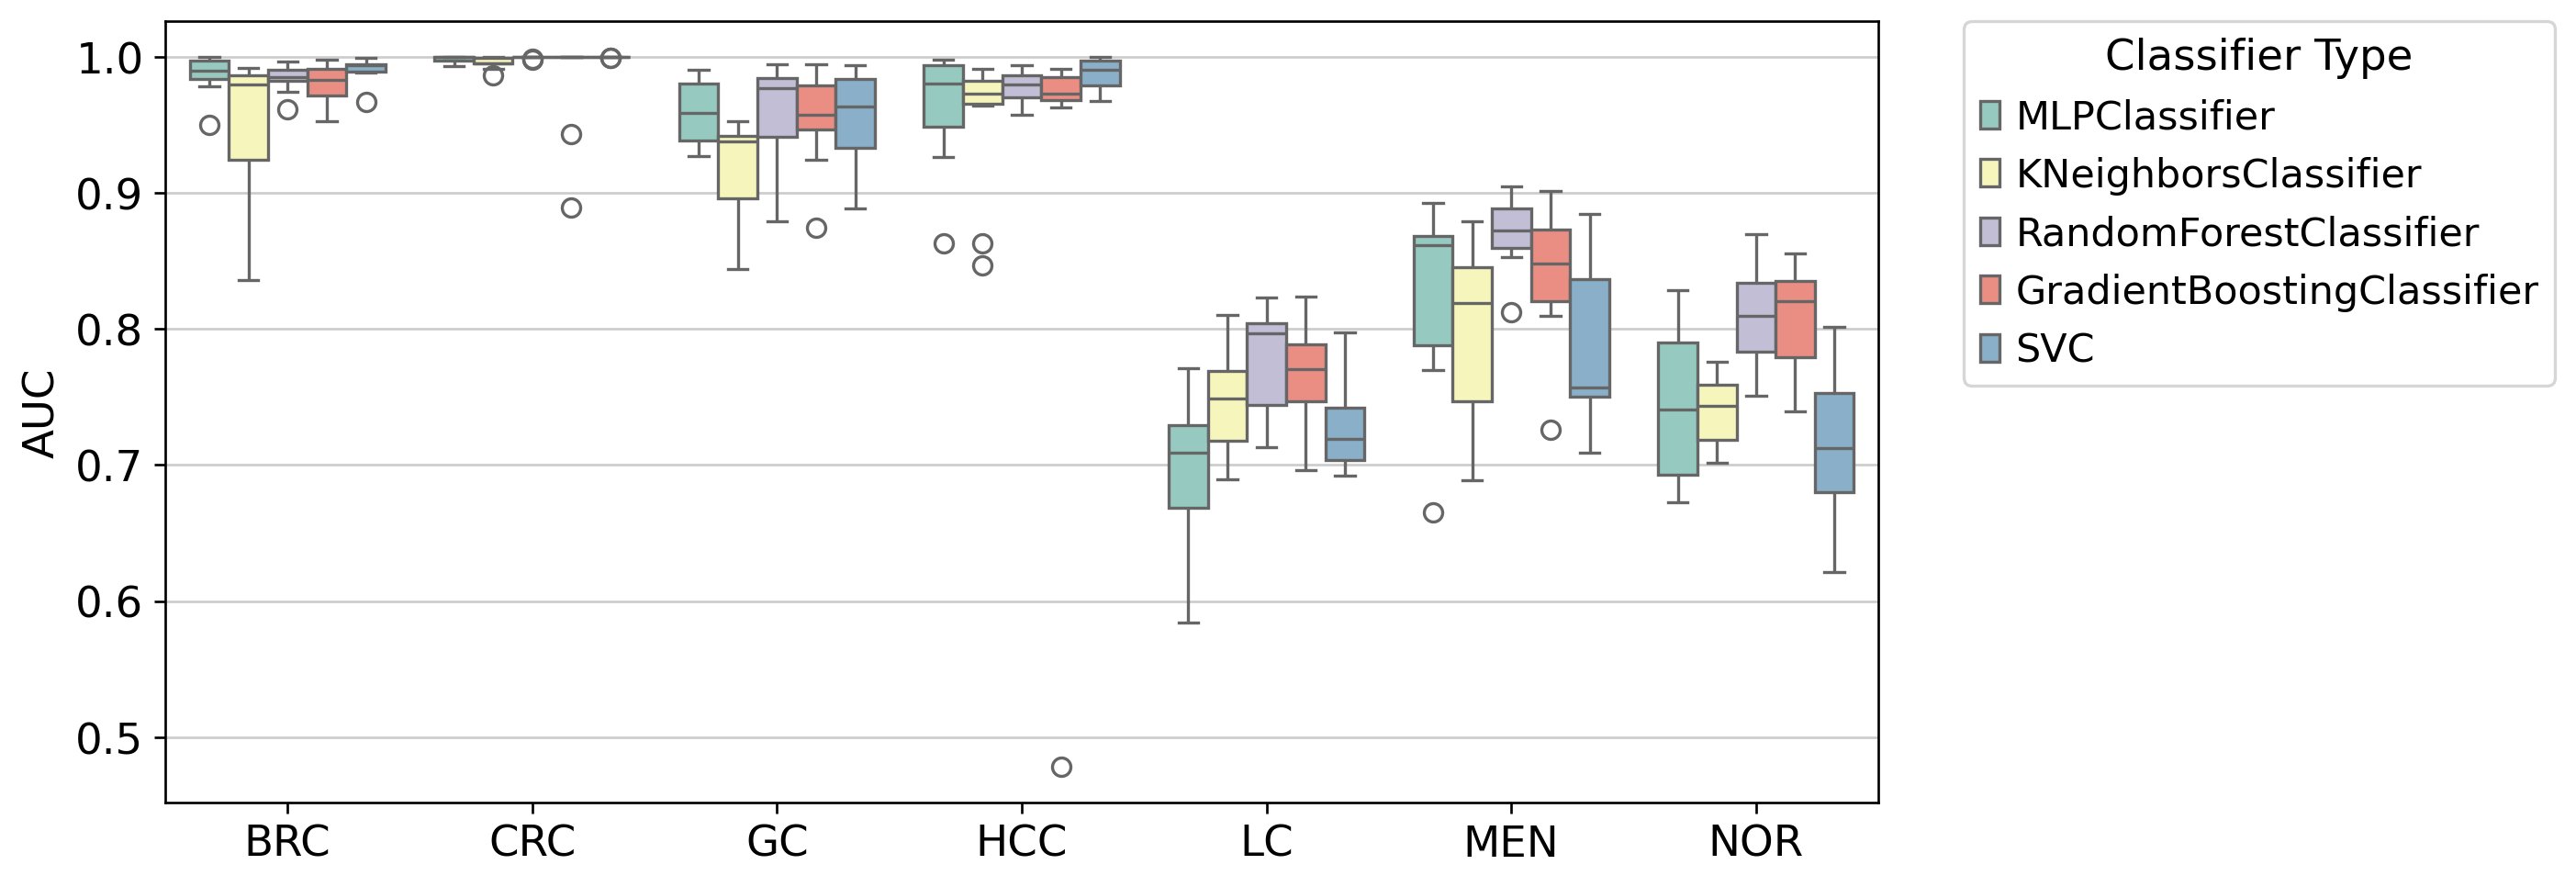

In [ ]:
# Loading the train data and drawing the boxplot
import pickle
file = '/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/ML_CA_target VS Oth.pkl'
train_results = joblib.load(file)


# Empty dictionary
data = {'seed': [], 'clf': [], 'auc': [], 'tpr': [], 'fpr': [], 'clf_type': [], 'target_class': [], 'precision': [], 'recall': [], 'aupr': [], 'f1score': []}
for res in train_results:
    data['seed'].append(res.seed)
    data['clf'].append(res.clf)
    data['auc'].append(res.auc)
    data['tpr'].append(res.tpr)
    data['fpr'].append(res.fpr)
    data['clf_type'].append(res.clf_type)
    data['target_class'].append(res.target_class)
    data['precision'].append(res.precision)
    data['recall'].append(res.recall)
    data['aupr'].append(res.aupr)
    data['f1score'].append(res.f1score)

df = pd.DataFrame(data)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype']  = 42
plt.figure(figsize=(12, 4.5))
ax = sns.boxplot(x="target_class", y="auc", hue="clf_type", data=df, palette="Set3").legend(title="Classifier Type", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# Move the legend outside of the plot and arrange it vertically
plt.legend(title="Classifier Type", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=1)
# Apply tight_layout to the whole figure, not the legend
plt.tight_layout()
plt.xlabel('')
plt.ylabel('AUC')
plt.savefig(f'/mnt/data3/yiyonghao/MicroRNA/plot/CA_MultiClass_AUCboxplot.pdf')

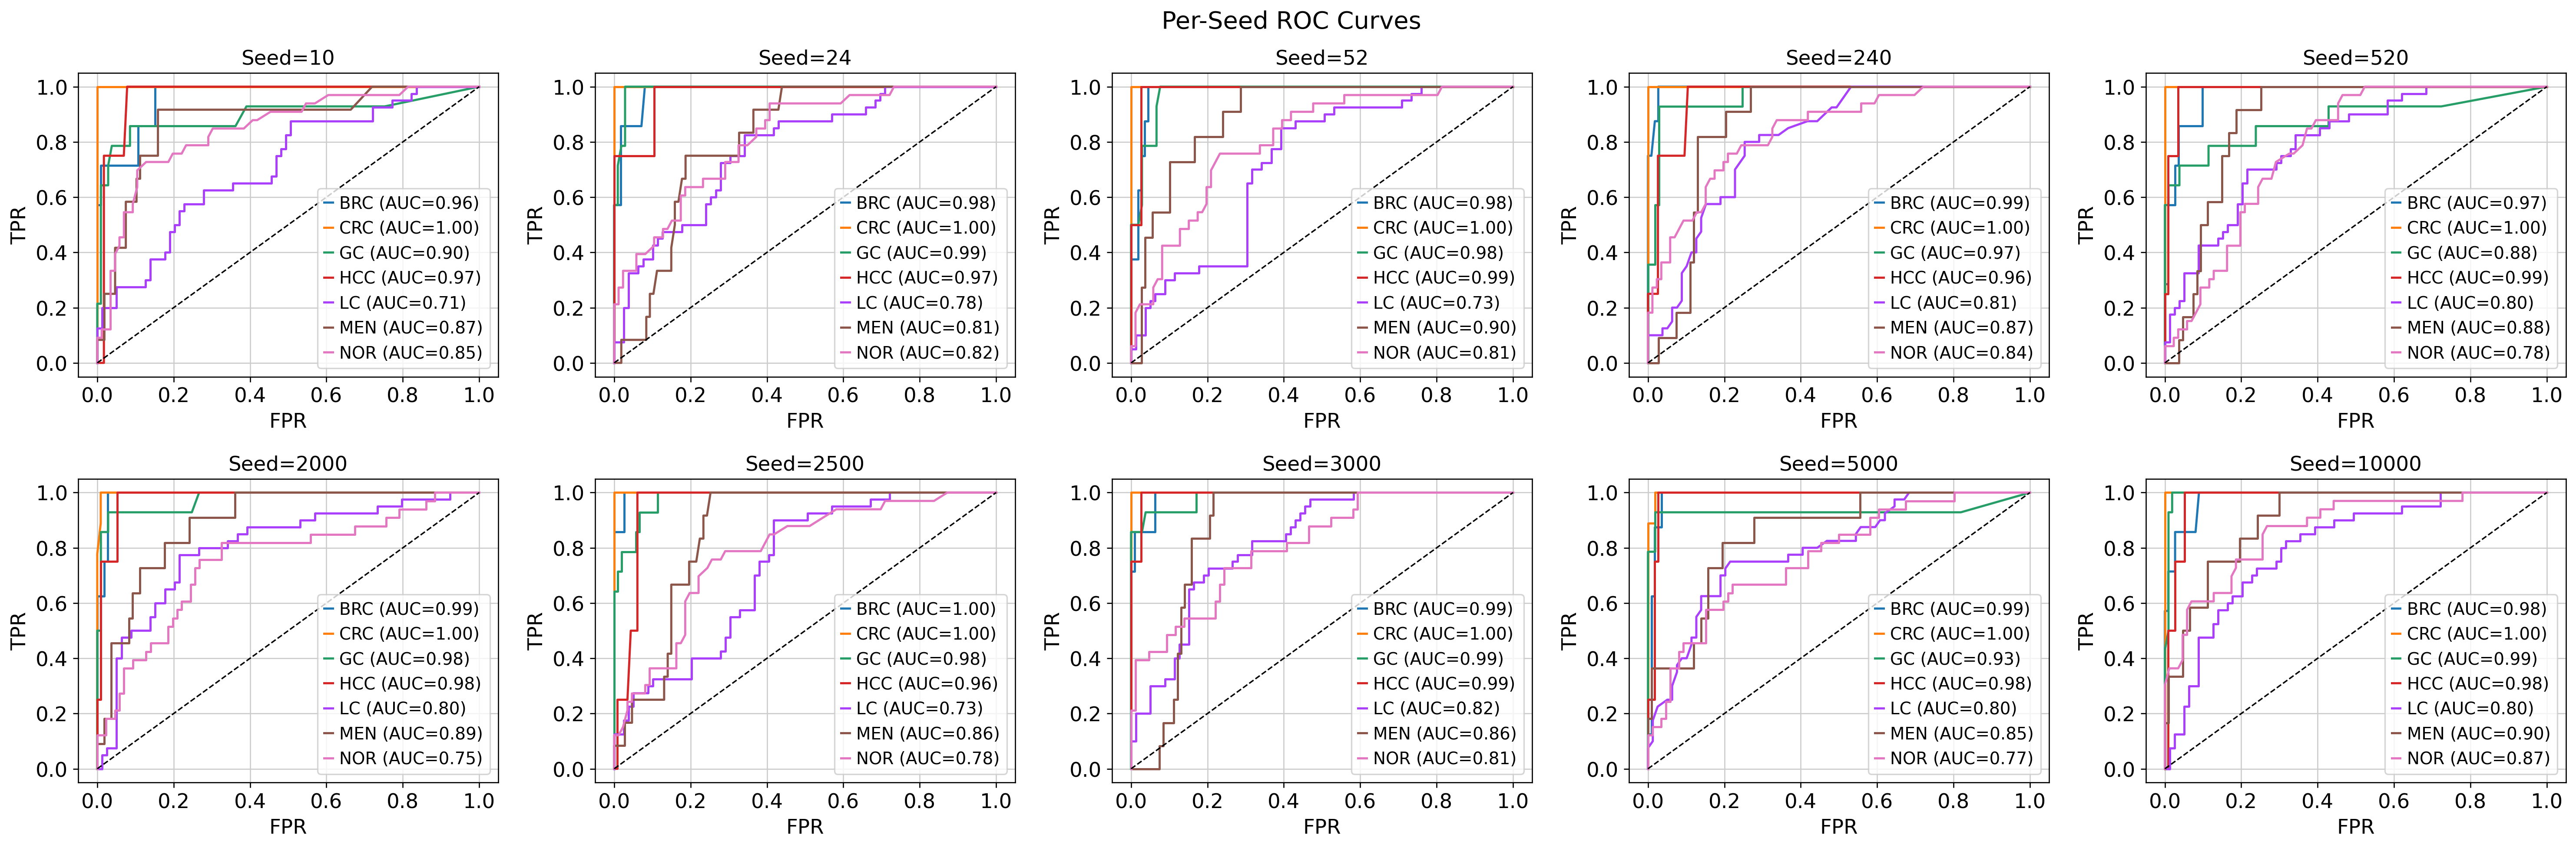

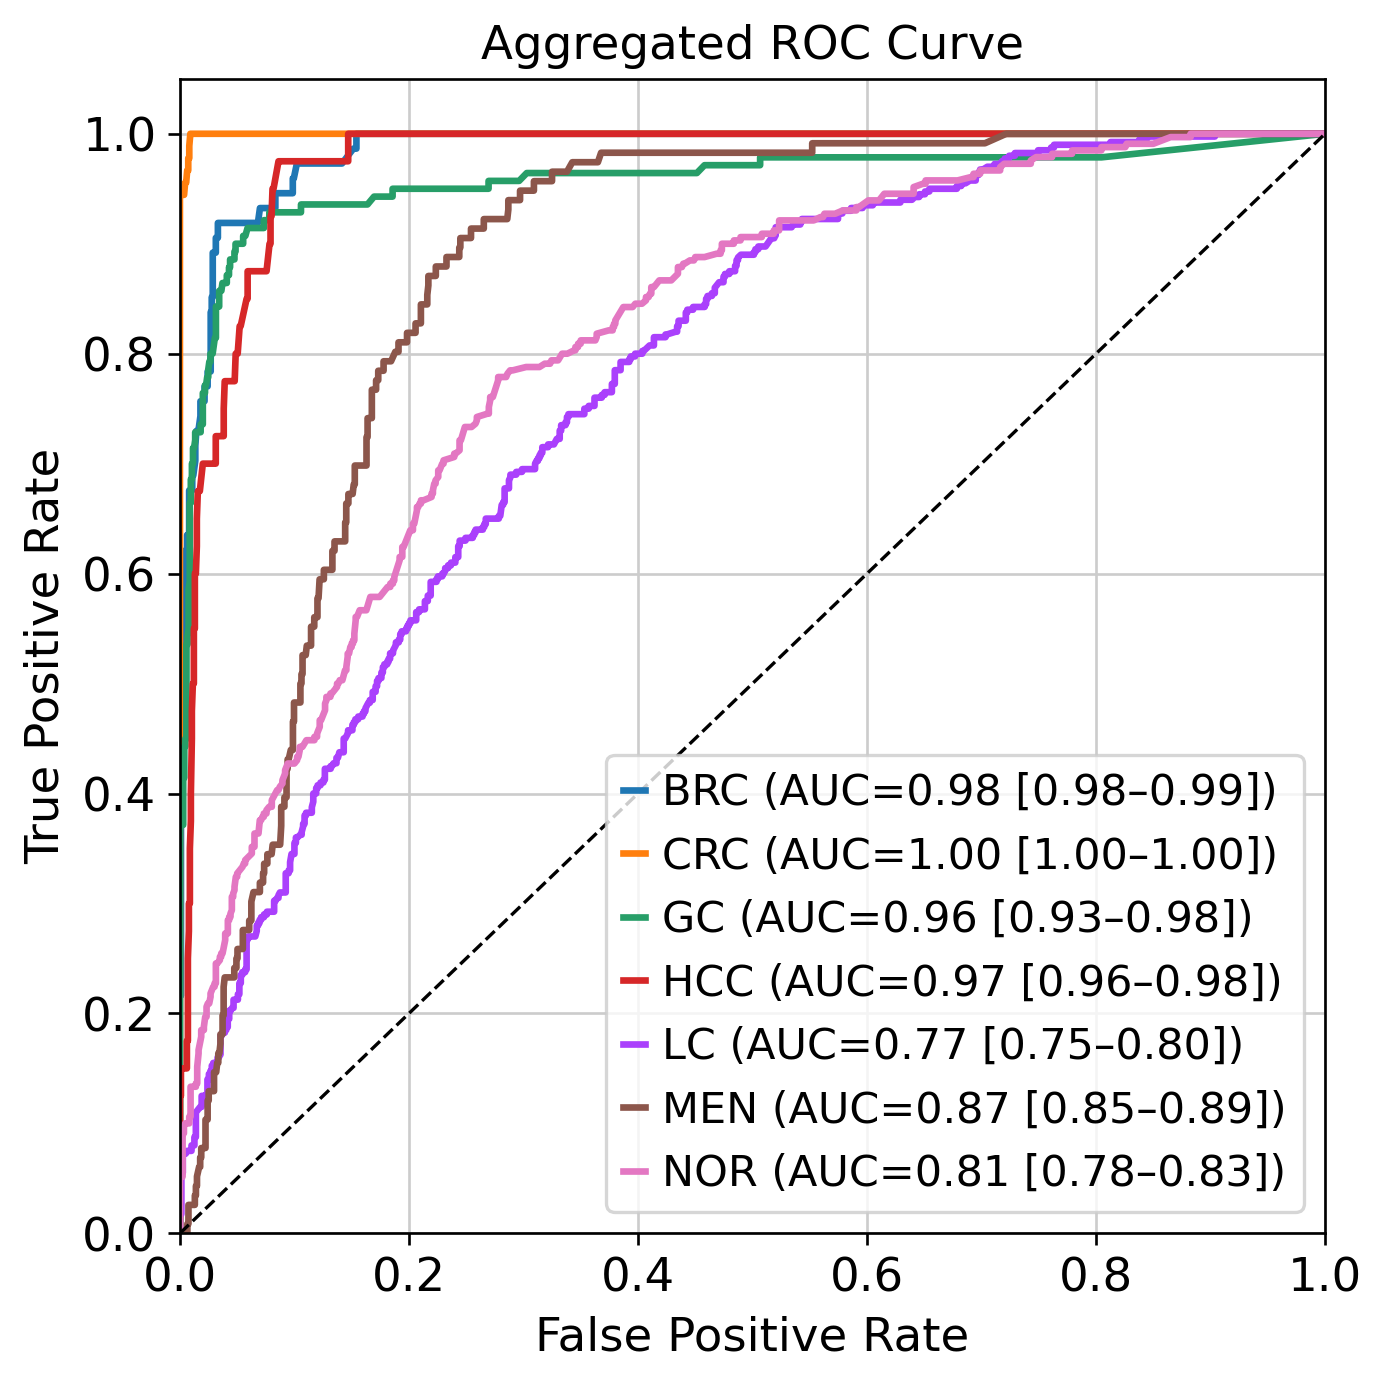

In [ ]:
# Soft-Vote global ROC curve
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample
from collections import defaultdict

class SoftVotingROCEvaluator:
    def __init__(self,
                 data_path,
                 features_path,
                 model_pkl_path,
                 selected_models=None,
                 test_size=0.25,
                 n_bootstraps=1000,
                 rng_seed=42):
        """
        selected_models: list of clf_type to include, or None for all.
        """
        # Validate files
        for p in (data_path, features_path, model_pkl_path):
            if not os.path.exists(p):
                raise FileNotFoundError(f"File not found: {p}")
        # Load data
        df = pd.read_csv(data_path, index_col=0)
        self.Y = df['group'].values
        X = df.drop(columns=['group'])
        scaler = StandardScaler().fit(X)
        self.X_scaled = pd.DataFrame(scaler.transform(X),
                                     index=df.index, columns=X.columns)
        # Load features
        feat_df = pd.read_csv(features_path)
        # Load models
        all_results = joblib.load(model_pkl_path)
        if selected_models:
            self.results = [r for r in all_results if r.clf_type in selected_models]
        else:
            self.results = all_results
        # Metadata
        self.seeds = sorted({r.seed for r in self.results})
        self.classes = sorted({r.target_class for r in self.results})
        self.feature_map = {
            seed: feat_df[str(seed)].dropna().tolist()
            for seed in self.seeds if str(seed) in feat_df.columns
        }
        self.test_size = test_size
        self.n_bootstraps = n_bootstraps
        self.rng_seed = rng_seed
        # Storage
        self.per_seed_results = {}   # seed -> list of dicts {class,fpr,tpr,auc}
        self.sample_votes = defaultdict(list)
        self.global_results = {}     # class -> dict {fpr,tpr,auc,ci_lo,ci_hi}

    def compute_per_seed(self):
        """Compute and store per-seed ROC data and collect votes."""
        for seed in self.seeds:
            feats = self.feature_map.get(seed, [])
            if not feats:
                continue
            Xtr, Xte, ytr, yte = train_test_split(
                self.X_scaled[feats], self.Y,
                test_size=self.test_size,
                random_state=seed,
                stratify=self.Y
            )
            yte_bin = label_binarize(yte, classes=self.classes)
            seed_list = []
            avg_probs = np.zeros_like(yte_bin, dtype=float)
            for i, cls in enumerate(self.classes):
                # collect models and predict
                probs_list = []
                for r in self.results:
                    if r.seed == seed and r.target_class == cls:
                        idx = list(r.clf.classes_).index(cls)
                        probs_list.append(r.clf.predict_proba(Xte.values)[:, idx])
                if probs_list:
                    avg = np.mean(probs_list, axis=0)
                    avg_probs[:, i] = avg
                    fpr, tpr, _ = roc_curve(yte_bin[:, i], avg)
                    seed_list.append({'class': cls, 'fpr': fpr, 'tpr': tpr,
                                      'auc': auc(fpr, tpr)})
                # else skip class
            # collect votes
            for j, sid in enumerate(Xte.index):
                self.sample_votes[sid].append((yte_bin[j], avg_probs[j]))
            self.per_seed_results[seed] = seed_list

    def plot_per_seed(self):
        """Plot per-seed ROC curves in a grid."""
        n = len(self.per_seed_results)
        cols = 5
        rows = int(np.ceil(n / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols,4*rows))
        axes = axes.flatten()
        for ax, (seed, recs) in zip(axes, self.per_seed_results.items()):
            for item in recs:
                ax.plot(item['fpr'], item['tpr'], lw=1.5,
                        label=f"{item['class']} (AUC={item['auc']:.2f})")
            ax.plot([0,1],[0,1],'k--', lw=1)
            ax.set_title(f"Seed={seed}")
            ax.set_xlabel("FPR"); ax.set_ylabel("TPR")
            ax.legend(loc="lower right", fontsize="small")
        for ax in axes[len(self.per_seed_results):]:
            fig.delaxes(ax)
        fig.tight_layout(); fig.suptitle("Per-Seed ROC Curves", y=1.02)
        plt.show()

    def print_seed_table(self):
        """Print table of per-seed AUC."""
        rows = []
        for seed, recs in self.per_seed_results.items():
            for item in recs:
                rows.append({'seed': seed,
                             'class': item['class'],
                             'AUC': item['auc']})
        df = pd.DataFrame(rows)
        pivot = df.pivot(index='seed', columns='class', values='AUC').round(3)
        #print("Per-seed AUC values:")
        #print(pivot)

    def compute_global(self):
        """Compute aggregated ROC and 95% CI for each class, pooling all seed-sample predictions."""
        for i, cls in enumerate(self.classes):
            truths = []
            probs  = []
            # sample_votes: {sample_id: [(truth_vec, prob_vec), ... per seed]}
            for recs in self.sample_votes.values():
                for truth_vec, prob_vec in recs:
                    truths.append(truth_vec[i])
                    probs.append(prob_vec[i])
            truths = np.array(truths)
            probs  = np.array(probs)

            # 1) ROC & AUC
            fpr, tpr, _   = roc_curve(truths, probs)
            auc_score     = auc(fpr, tpr)

            # 2) Bootstrap 95% CI
            bs_scores = []
            n = len(truths)
            for b in range(self.n_bootstraps):
                idx = resample(
                    np.arange(n),
                    replace=True,
                    random_state=self.rng_seed + b
                )
                if len(np.unique(truths[idx])) < 2:
                    continue
                bs_scores.append(roc_auc_score(truths[idx], probs[idx]))
            ci_lo = np.percentile(bs_scores, 2.5) if bs_scores else np.nan
            ci_hi = np.percentile(bs_scores,97.5) if bs_scores else np.nan

            # store
            self.global_results[cls] = {
                'fpr':    fpr,
                'tpr':    tpr,
                'auc':    auc_score,
                'ci_lo':  ci_lo,
                'ci_hi':  ci_hi
            }


    def plot_global(self):
        """Plot aggregated ROC with 95% CI in legend."""
        mpl.rcParams['pdf.fonttype'] = 42
        mpl.rcParams['ps.fonttype']  = 42
        plt.figure(figsize=(6,6))
        for cls, res in self.global_results.items():
            plt.plot(res['fpr'], res['tpr'], lw=2,
                     label=f"{cls} (AUC={res['auc']:.2f} [{res['ci_lo']:.2f}–{res['ci_hi']:.2f}])")
        plt.plot([0,1],[0,1],'k--', lw=1)
        plt.xlim([0,1]); plt.ylim([0,1.05])
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
        plt.title("Aggregated ROC Curve")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig('/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/CA_Muliti_ROC.pdf')
        plt.show()
       

# Usage:
if __name__ == "__main__":
    evaluator = SoftVotingROCEvaluator(
        data_path='/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/CA_selected_Masslin2_0801.csv',
        features_path='/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/selected_features_CA.csv',
        model_pkl_path='/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/ML_CA_target VS Oth.pkl',
        selected_models=['RandomForestClassifier']
    )
    evaluator.compute_per_seed()
    evaluator.plot_per_seed()
    evaluator.print_seed_table()
    evaluator.compute_global()
    evaluator.plot_global()



In [ ]:
# Summary the model performance
import os
import joblib
import numpy as np
import pandas as pd
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_recall_curve, auc as sk_auc,
    f1_score, recall_score, precision_score, accuracy_score
)
from sklearn.utils import resample

class ModelMetricsAggregator:
    def __init__(self,
                 data_path: str,
                 features_path: str,
                 model_pkl_path: str,
                 test_size: float = 0.25,
                 n_thresh: int = 200,
                 n_bootstraps: int = 1000,
                 rng_seed: int = 42):
        # 1. check the files
        for p in (data_path, features_path, model_pkl_path):
            if not os.path.exists(p):
                raise FileNotFoundError(f"File not found: {p}")
            
        df        = pd.read_csv(data_path, index_col=0)
        self.Y    = df['group'].values
        X          = df.drop(columns=['group'])

        scaler     = StandardScaler().fit(X)
        Xs         = scaler.transform(X)
        self.X     = pd.DataFrame(Xs, index=df.index, columns=X.columns)

        feat_df    = pd.read_csv(features_path)

        results    = joblib.load(model_pkl_path)

        self.models_df = pd.DataFrame([{
            'seed': r.seed,
            'model': r.clf_type,
            'target_class': r.target_class,
            'clf': r.clf
        } for r in results])

        self.seeds       = sorted(self.models_df['seed'].unique())
        self.models      = sorted(self.models_df['model'].unique())
        self.classes     = sorted(np.unique(self.Y))

        self.feature_map = {
            seed: feat_df[str(seed)].dropna().tolist()
            for seed in self.seeds
            if str(seed) in feat_df.columns
        }

        self.test_size    = test_size
        self.n_thresh     = n_thresh
        self.n_bootstraps = n_bootstraps
        self.rng_seed     = rng_seed


        self.df_seed_metrics   = None
        self.df_pooled_metrics = None

    def compute_per_seed_metrics(self):
        records = []
        # pooled 
        pooled = defaultdict(lambda: {'truths': [], 'probs': []})

        for seed in self.seeds:
            feats = self.feature_map.get(seed, [])
            if not feats:
                continue
            # strsplit
            Xtr, Xte, ytr, yte = train_test_split(
                self.X[feats], self.Y,
                test_size=self.test_size,
                random_state=seed,
                stratify=self.Y
            )
            # calculated metrics
            for model in self.models:
                df_sub = self.models_df[
                    (self.models_df.seed == seed) &
                    (self.models_df.model == model)
                ]
                if df_sub.empty:
                    continue
                for cls in df_sub['target_class'].unique():
                    sub = df_sub[df_sub.target_class == cls]
                    y_true_bin = (yte == cls).astype(int)
                    # soft vote
                    prob_list = []
                    for _, row in sub.iterrows():
                        clf = row['clf']
                        pos_idx = list(clf.classes_).index(cls)
                        prob_list.append(clf.predict_proba(Xte)[:, pos_idx])
                    avg_prob = np.mean(prob_list, axis=0)

                    # accumulate pooled
                    key = (model, cls)
                    pooled[key]['truths'].extend(y_true_bin.tolist())
                    pooled[key]['probs'].extend(avg_prob.tolist())

                    auc_sc = roc_auc_score(y_true_bin, avg_prob)
                    pr, rc, _ = precision_recall_curve(y_true_bin, avg_prob)
                    aupr = sk_auc(rc, pr)
                    ths = np.linspace(0,1,self.n_thresh)
                    f1s = [f1_score(y_true_bin, (avg_prob >= t).astype(int)) for t in ths]
                    best_t = ths[int(np.argmax(f1s))]
                    ypred = (avg_prob >= best_t).astype(int)
                    tn = ((y_true_bin==0)&(ypred==0)).sum()
                    fp = ((y_true_bin==0)&(ypred==1)).sum()
                    sens = recall_score(y_true_bin, ypred, zero_division=0)
                    spec = tn/(tn+fp) if (tn+fp)>0 else np.nan
                    prec = precision_score(y_true_bin, ypred, zero_division=0)
                    f1   = f1_score(y_true_bin, ypred)
                    youd = sens + spec - 1
                    acc  = accuracy_score(y_true_bin, ypred)

                    records.append({
                        'model':        model,
                        'seed':         seed,
                        'target_class': cls,
                        'AUC':          auc_sc,
                        'AUPR':         aupr,
                        'F1':           f1,
                        'threshold':    best_t,
                        'youden_index': youd,
                        'precision':    prec,
                        'sensitivity':  sens,
                        'specificity':  spec,
                        'accuracy':     acc
                    })

        self.df_seed_metrics = pd.DataFrame(records)
        self.pooled = pooled
        return self.df_seed_metrics

    def compute_pooled_metrics(self):
        records = []

        for (model, cls), data in self.pooled.items():
            truths = np.array(data['truths'])
            probs  = np.array(data['probs'])

            # —— Pooled AUC & ROC curve ——
            fpr, tpr, _ = roc_curve(truths, probs)
            auc_sc = roc_auc_score(truths, probs)

            # —— Bootstrap 95% CI —— 
            bs_scores = []
            n = len(truths)
            for b in range(self.n_bootstraps):
                idx = resample(
                    np.arange(n),
                    replace=True,
                    random_state=self.rng_seed + b
                )
                if len(np.unique(truths[idx])) < 2:
                    continue
                bs_scores.append(roc_auc_score(truths[idx], probs[idx]))
            ci_lo = np.percentile(bs_scores, 2.5) if bs_scores else np.nan
            ci_hi = np.percentile(bs_scores, 97.5) if bs_scores else np.nan

            # —— Pooled AUPR —— 
            pr, rc, _ = precision_recall_curve(truths, probs)
            aupr = sk_auc(rc, pr)

            # —— best threshold & F1 —— 
            ths = np.linspace(0, 1, self.n_thresh)
            f1s = [
                f1_score(truths, (probs >= t).astype(int), zero_division=0)
                for t in ths
            ]
            best_idx = int(np.argmax(f1s))
            best_t  = ths[best_idx]
            f1_best = f1s[best_idx]

            # —— confusion —— 
            ypred = (probs >= best_t).astype(int)
            tn = np.sum((truths == 0) & (ypred == 0))
            fp = np.sum((truths == 0) & (ypred == 1))
            sens = recall_score(truths, ypred, zero_division=0)
            spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
            prec = precision_score(truths, ypred, zero_division=0)
            youd = sens + spec - 1
            acc  = accuracy_score(truths, ypred)

            records.append({
                'model':         model,
                'seed':          'mean',
                'target_class':  cls,
                'AUC':           auc_sc,
                'AUC_CI_lower':  ci_lo,
                'AUC_CI_upper':  ci_hi,
                'AUPR':          aupr,
                'F1':            f1_best,
                'threshold':     best_t,
                'youden_index':  youd,
                'precision':     prec,
                'sensitivity':   sens,
                'specificity':   spec,
                'accuracy':      acc
            })

        self.df_pooled_metrics = pd.DataFrame(records)

        # combined result
        df_mean = self.df_pooled_metrics.copy()
        cols_order = [
            'model','seed','target_class',
            'AUC','AUC_CI_lower','AUC_CI_upper',
            'AUPR','F1','threshold',
            'youden_index','precision','sensitivity','specificity','accuracy'
        ]
        df_mean = df_mean[cols_order]

        self.df_combined = pd.concat(
            [self.df_seed_metrics, df_mean],
            ignore_index=True,
            sort=False
        )

        return self.df_pooled_metrics



    def save(self, prefix):
        """Save both tables."""
        self.df_combined.to_csv(f"{prefix}_combined.csv", index=False)


if __name__ == "__main__":
    data_path     = '/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/CA_selected_Masslin2_0801.csv'
    features_path = '/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/selected_features_CA.csv'
    model_pkl     = '/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/ML_CA_target VS Oth.pkl'

    agg = ModelMetricsAggregator(data_path, features_path, model_pkl)
    df_seed   = agg.compute_per_seed_metrics()
    df_pooled = agg.compute_pooled_metrics()
    agg.save('/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/All_models_metrics_CA')
    print("\nThe all models metrics is generated!!")


The all models metrics is generated!!


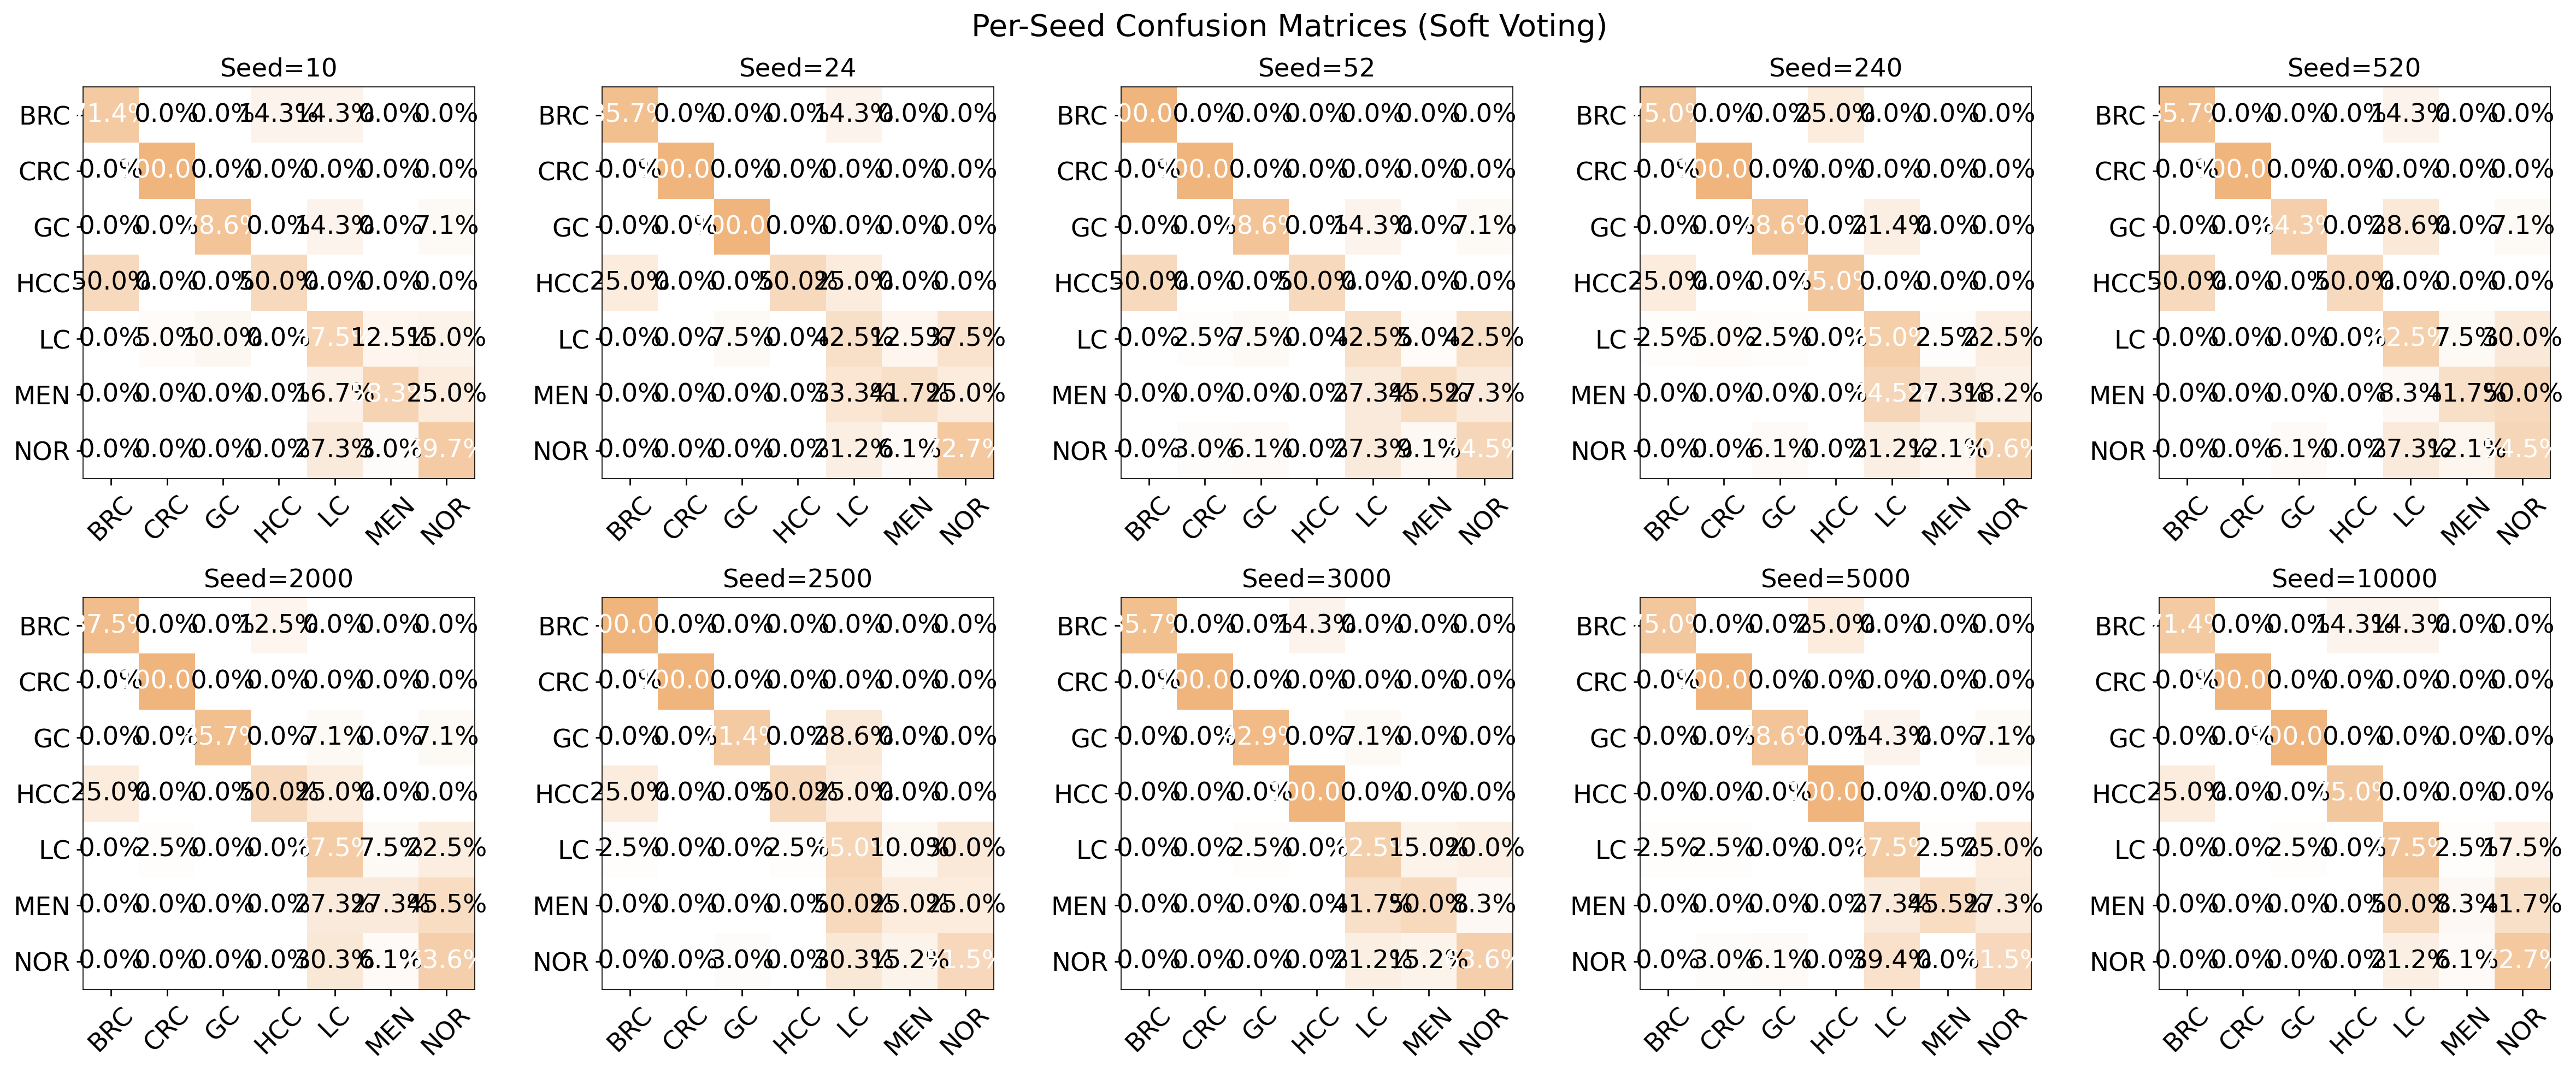

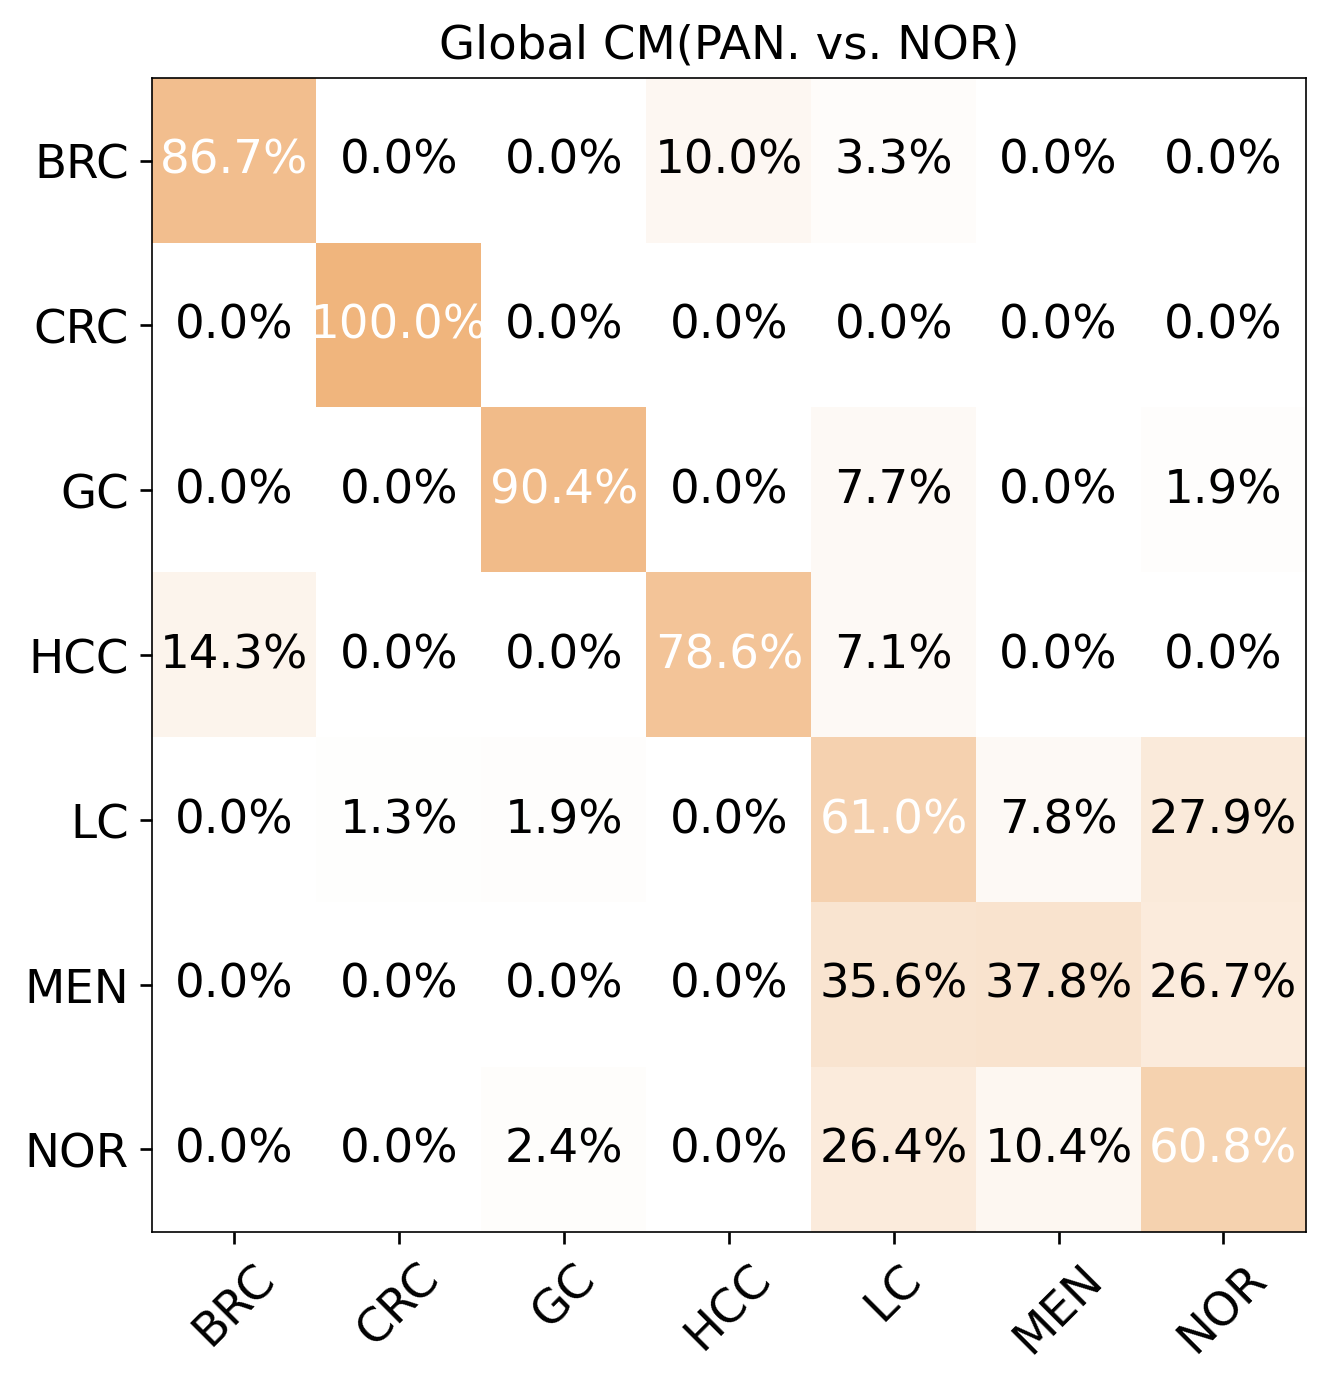

In [ ]:
# global confuse matrix
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from collections import defaultdict
import matplotlib as mpl

class SoftVotingConfusionEvaluator:
    def __init__(self,
                 data_path: str,
                 features_path: str,
                 model_pkl_path: str,
                 selected_models: list = None,
                 test_size: float = 0.25,
                 random_state: int = 42):
        """
        Parameters:
        - data_path: CSV with 'group' column.
        - features_path: CSV where each seed column lists selected features.
        - model_pkl_path: Pickle list of results with attributes seed, target_class, clf.
        - selected_models: list of clf_type strings to include, or None for all.
        - test_size: fraction of data to hold out per seed.
        - random_state: seed for reproducible splitting and operations.
        """
        # Validate
        for p in (data_path, features_path, model_pkl_path):
            if not os.path.exists(p):
                raise FileNotFoundError(f"File not found: {p}")

        # Load data & scale
        df = pd.read_csv(data_path, index_col=0)
        self.labels = df['group'].values
        X = df.drop(columns=['group'])
        scaler = StandardScaler().fit(X)
        self.X_scaled = pd.DataFrame(
            scaler.transform(X),
            index=df.index,
            columns=X.columns
        )

        # Load features
        feat_df = pd.read_csv(features_path)

        # Load model results
        all_results = joblib.load(model_pkl_path)
        if selected_models:
            self.results = [r for r in all_results if getattr(r, 'clf_type', None) in selected_models]
        else:
            self.results = all_results

        # Metadata
        self.seeds = sorted({r.seed for r in self.results})
        self.classes = sorted({r.target_class for r in self.results})
        # Feature map per seed
        self.feature_map = {
            seed: feat_df[str(seed)].dropna().tolist()
            for seed in self.seeds if str(seed) in feat_df.columns
        }

        # Config
        self.test_size = test_size
        self.random_state = random_state
        # Colormap for confusion matrix
        self.cmap = LinearSegmentedColormap.from_list('custom_orange', ['#FFFFFF', '#F0b57D'], N=256)

        # Storage
        self.per_seed_cm = {}        # seed -> confusion matrix
        self.sample_votes = defaultdict(list)
        self.global_cm = None

    def _plot_cm(self, ax, cm, labels):
        """Plot percentage confusion matrix on ax."""
        cm_pct = cm / cm.sum(axis=1, keepdims=True) * 100
        thresh = cm_pct.max() / 2
        im = ax.imshow(cm_pct, interpolation='nearest', cmap=self.cmap, aspect='equal')
        ax.set_xticks(np.arange(len(labels)))
        ax.set_yticks(np.arange(len(labels)))
        ax.set_xticklabels(labels, rotation=45)
        ax.set_yticklabels(labels)
        ax.grid(False)
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.5)
            spine.set_edgecolor('black')
        for i in range(cm_pct.shape[0]):
            for j in range(cm_pct.shape[1]):
                val = cm_pct[i, j]
                ax.text(j, i, f"{val:.1f}%",
                        ha='center', va='center',
                        color='white' if val > thresh else 'black')

    def compute_per_seed_confusions(self):
        """Compute and store per-seed confusion matrices and accumulate votes."""
        for seed in self.seeds:
            # split
            X_tr, X_te, y_tr, y_te = train_test_split(
                self.X_scaled, self.labels,
                test_size=self.test_size,
                stratify=self.labels,
                random_state=seed
            )
            feats = self.feature_map.get(seed, [])
            if not feats:
                continue
            X_te_sel = X_te[feats]

            # compute soft-vote probabilities
            probs_matrix = np.zeros((len(y_te), len(self.classes)))
            for i, cls in enumerate(self.classes):
                models = [r.clf for r in self.results
                          if r.seed == seed and r.target_class == cls]
                if not models:
                    continue
                cls_probs = np.column_stack([
                    m.predict_proba(X_te_sel.values)[:, list(m.classes_).index(cls)]
                    for m in models
                ])
                probs_matrix[:, i] = np.mean(cls_probs, axis=1)

            # accumulate each sample's truth & prob vector
            for idx, sample_id in enumerate(X_te_sel.index):
                self.sample_votes[sample_id].append((y_te[idx], probs_matrix[idx]))

            # derive predictions by argmax
            y_pred = [self.classes[np.argmax(row)] for row in probs_matrix]
            cm = confusion_matrix(y_te, y_pred, labels=self.classes)
            self.per_seed_cm[seed] = cm
        return self.per_seed_cm

    def plot_per_seed_confusions(self, cols: int = 5):
        """Plot all per-seed confusion matrices in a grid."""
        n = len(self.per_seed_cm)
        rows = int(np.ceil(n / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
        axes = axes.flatten()
        for ax, (seed, cm) in zip(axes, self.per_seed_cm.items()):
            self._plot_cm(ax, cm, self.classes)
            ax.set_title(f"Seed={seed}")
        # remove extras
        for ax in axes[n:]:
            fig.delaxes(ax)
        fig.tight_layout()
        fig.suptitle("Per-Seed Confusion Matrices (Soft Voting)", y=1.02)
        plt.show()

    def compute_aggregated_confusion(self):
        """Compute confusion matrix aggregated across all seeds by soft voting."""
        final_true = []
        final_pred = []
        for sample_id, recs in self.sample_votes.items():
            truths, probs = zip(*recs)
            # assume truths all same for each seed
            final_true.append(truths[0])
            avg_prob = np.mean(probs, axis=0)
            final_pred.append(self.classes[int(np.argmax(avg_prob))])
        self.global_cm = confusion_matrix(final_true, final_pred, labels=self.classes)
        return self.global_cm

    def plot_aggregated_confusion(self):
        mpl.rcParams['pdf.fonttype'] = 42
        mpl.rcParams['ps.fonttype']  = 42
        """Plot the aggregated confusion matrix."""
        if self.global_cm is None:
            raise ValueError("Call compute_aggregated_confusion() first.")
        fig, ax = plt.subplots(figsize=(6,6))
        self._plot_cm(ax, self.global_cm, self.classes)
        ax.set_title(f'Global CM(PAN. vs. NOR)')
        fig.tight_layout()
        plt.savefig('/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/CA_Multi_cm.pdf')
        plt.show()

    def get_top_features_per_seed(self, topn: int = 50) -> dict:
        """
        Extract top 'topn' features by average feature_importances_
        for RandomForestClassifier (unwrapped from GridSearchCV).
        Returns { seed: Series(feature -> importance) }.
        """
        seed_importances = {}

        for seed in self.seeds:
            feats = self.feature_map.get(seed, [])
            if not feats:
                continue

            rf_models = []
            for r in self.results:
                if r.seed != seed or r.clf_type != 'RandomForestClassifier':
                    continue

                clf = r.clf.best_estimator_
                if isinstance(clf, RandomForestClassifier):
                    rf_models.append(clf)

            if not rf_models:
                print(f"Seed={seed} 没匹配到任何 RandomForestClassifier")
                continue

            imps = np.vstack([m.feature_importances_ for m in rf_models])
            mean_imp = imps.mean(axis=0)
            imp_series = pd.Series(mean_imp, index=feats)
            seed_importances[seed] = imp_series.nlargest(topn)

        return seed_importances


# usage:
evaluator = SoftVotingConfusionEvaluator(data_path = '/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/CA_selected_Masslin2_0801.csv',
                                         features_path = '/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/selected_features_CA.csv', 
                                         model_pkl_path = '/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/ML_CA_target VS Oth.pkl')
evaluator.compute_per_seed_confusions()
evaluator.plot_per_seed_confusions()
evaluator.compute_aggregated_confusion()
evaluator.plot_aggregated_confusion()


In [ ]:
#　Arrange top50 RF features based on mean importance
import pandas as pd
top_feats = evaluator.get_top_features_per_seed(topn=50)
top_feats = pd.DataFrame(top_feats)
top_feats.to_csv('/mnt/data3/yiyonghao/MicroRNA/process_file/2_Multi_training/CA_Multi_featureImp.csv')